# Example of generating perturbed parameters

## Load MCE package and other dependencies

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
from netCDF4 import Dataset
from io import StringIO
from mce.util.io import read_ncfile
from mce.core.genparms import PcaParmsCmip
from mce.core.driver import Driver
from mce.util.input_rcmip import InputRcmip
from mce.util.parms_perturbed import ParmsPerturbed
from mce.util.stat import StatModel, SamplingMH
from mce.util.plot import wrap_plotspace
import matplotlib as mpl
import textwrap
from IPython.display import display

### Load a calibration function for MCE ocean carbon cycle

Currently, this function is not publicly available.

In [2]:
import sys
path_untracked = '../untracked'
if path_untracked not in sys.path:
    sys.path.append(path_untracked)

try:
    from calib_ocean import calib_ocean
    from mce.core.carbon import ModelOcean

except:
    calib_ocean = None

### Load RCMIP time series for calibration

Available from the project's GitLab repository at https://gitlab.com/rcmip/rcmip.

In [3]:
try:
    input_rcmip = InputRcmip('../untracked/rcmip', 'v4-0-0')
except:
    input_rcmip = None

### Load namedtuple and define a parameter name container

In [4]:
from collections import namedtuple
Variable = namedtuple('Variable', ['long_name', 'units'])
names_parm = {}

## Building perturbed parameters

The MCE model is essentially built on impulse response functions for the fraction of the total CO<sub>2</sub> emitted that remains in the atmosphere (termed the airborne fraction), the decay of land carbon accumulated by the CO<sub>2</sub> fertilization effect, and temperature change to radiative forcing of CO<sub>2</sub> and other forcing agents. Under the linear response assumption with regard to input forcing $F$, an impulse response model (IRM) expresses the time change of a response variable $x$ by a convolution integral:
$$
x(t) = \int_{0}^{t} F(t^{'}) \sum_{i} A_{i}
\exp\left( -\frac{t-t'}{\tau_{i}}\right) dt^{'},
$$
where $t$ is time, and the sum of exponentials is an impulse response function with parameters $A_i$ and $\tau_i$ denoting the $i$-th component of the response amplitude and time constant, respectively. The time derivative of this equation is given by:
$$
\frac{dx(t)}{dt} = \sum_{i}
\left[ F(t) A_{i} - \frac{x_{i}(t)}{\tau_{i}} \right],
$$
or an equivalent box model form that is converted into the original IRM through Laplace transform or eigenfunction expansion. The time derivative implemented in the MCE uses an IRM form for land carbon decay and temperature change, and a box model form for the airborne fraction, to address partitioning of excess carbon between the atmosphere and ocean mixed layer.

There are a number of uncertain parameters, not only for the IRM amplitudes and time constants, but also for several control parameters used in forcing terms. To deal with these uncertainties, probabilistic runs are conducted with an ensemble of perturbed model parameters designed to encompass the variation of multiple CMIP models with additional constraints with regard to key indicators.

In general, a series of candidate values of an uncertain parameter is generated from its statistical model and, if necessary, sampled from the series with an acceptance algorithm for given constraints. The latter process is Bayesian updating from a prior probability distribution to a posterior and here uses a Metropolis-Hastings (MH) independence sampler.

## Temperature response parameters

The temperature response parameters are synthetically generated with CO<sub>2</sub> forcing parameters from a multivariate normal distribution, built on principal components (PCs) of diagnosed parameters for each of the CMIP models.

In the standard configuration, the IRM of the temperature change defines three components with typical time constants of approximately 1, 10, and > 100 years. The response amplitude is rewritten by $\tilde{A}_i/(\lambda \tau_i)$, where $\tilde{A}_i$ is normalized so that the component sum is unity, and $\lambda$ is the climate feedback parameter in W/m<sup>2</sup>/degC, defined as the derivative of the outgoing thermal flux with respect to temperature change.

CO<sub>2</sub> forcing is evaluated with the following quadratic formula, in terms of the logarithm of CO<sub>2</sub> concentration:
$$
F_{\mathrm{C}}(x) = (\beta_{\mathrm{C}} - 1)
[\hat{F}_{\mathrm{C}}(x) - 2F_{\mathrm{C}}(2)]
[2\hat{F}_{\mathrm{C}}(x)/F_{\mathrm{C}}(2) - 1]
+ \beta_{\mathrm{C}} \hat{F}_{\mathrm{C}}(x)
$$
$$
\hat{F}_{\mathrm{C}}(x) = \alpha_{\mathrm{C}}
\ln [\mathrm{CO_{2}(t)/\mathrm{CO_{2}(0)}}],
$$
where $x$ is the ratio of CO<sub>2</sub> concentrations to a preindustrial level, $\alpha_{\mathrm{C}}$ is a scaling parameter in W/m<sup>2</sup>, and $\beta_{\mathrm{C}}$ is an amplification factor defined as $F_{\mathrm{C}}(4) = \beta_{\mathrm{C}} \times \hat{F}_{\mathrm{C}}(4)$.

The quadratic term is activated when the concentration exceeds a two-times level ($x>2$), and $\beta_{\mathrm{C}}$ is set to unity in the range $x \le 2$ so that $F_{\mathrm{C}}$ is equivalent to $\hat{F}_{\mathrm{C}}$. The forcing amplification is expected to be valid in the range $x \le 4$ and the quadratic term is dropped beyond a four-time level.

### Prepare climate response parameters of CMIP5 and CMIP6 model ensembles

Input netcdf files are the output of `mce/script/diag_climate.py`, as demonstrated in `t_diag_climate` notebook.

In [5]:
map_names = {f'amplitude_{i}': f'a{i}' for i in range(3)}
map_names.update({f'time_constant_{i}': f'tau{i}' for i in range(3)})
df_parms_cmip = []

for mip in ['cmip5', 'cmip6']:
    # variables are returned as dictionary elements
    df = read_ncfile(
        f'../mce/data/parms/parms_irm-3_rtnt-tas_{mip}.nc')
    # model name needs to be converted from characters to a string
    df['dataset'] = [''.join(x.astype(str)).strip() for x in df['dataset']]
    # make a DataFrame and change response parameter names to their short forms
    df = pd.DataFrame(df).rename(columns=map_names)
    # add mip era
    df['mip'] = mip
    df_parms_cmip.append(df)

df_parms_cmip = (
    pd.concat(df_parms_cmip, sort=False)
    .set_index(['dataset', 'mip'])
    .sort_index(axis=1)
    .reset_index()
)
df_parms_cmip

[2021-10-12 09:14:24 mce] INFO:reading ../mce/data/parms/parms_irm-3_rtnt-tas_cmip5.nc
[2021-10-12 09:14:24 mce] INFO:reading ../mce/data/parms/parms_irm-3_rtnt-tas_cmip6.nc


,dataset,mip,a0,a1,a2,alpha,beta,ecs,ecs_reg,lambda,lambda_reg,tau0,tau1,tau2,tcr,tcr_gcm
0,ACCESS1.0,cmip5,0.309628,0.186450,0.503922,4.246666,1.019410,3.750815,3.827931,0.784780,0.777060,1.770429,11.857424,219.715468,1.982800,1.921747
1,ACCESS1.3,cmip5,0.183242,0.311261,0.505497,3.925013,1.075596,3.261574,3.531926,0.834141,0.819500,1.085171,7.639266,255.390396,1.697960,1.631630
2,BCC-CSM1.1,cmip5,0.349606,0.278788,0.371607,4.450617,1.037867,2.729098,2.826381,1.130386,1.137433,1.676995,9.769733,141.681350,1.798378,1.736432
3,BNU-ESM,cmip5,0.288810,0.349391,0.361799,5.453803,1.007903,3.896504,3.923890,0.970174,0.966931,1.253887,9.062490,291.686972,2.445168,2.490674
4,CanESM2,cmip5,0.447780,0.222860,0.329360,5.352112,1.018086,3.642714,3.691430,1.018417,1.038722,2.171483,21.435611,261.563893,2.298461,2.340212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,NESM3,cmip6,0.383838,0.270066,0.346096,5.571190,1.048372,4.434479,4.715919,0.870825,0.801938,0.688722,18.372645,411.292266,2.697093,2.709527
59,NorESM2-LM,cmip6,0.071591,0.519193,0.409216,4.070008,1.178675,2.194624,2.536783,1.285466,1.380486,0.043158,1.821879,228.466186,1.390649,1.475827
60,NorESM2-MM,cmip6,0.146193,0.483427,0.370381,4.296145,1.211972,2.084728,2.498568,1.428417,1.472066,0.066863,2.321184,217.483061,1.390161,1.335450
61,SAM0-UNICON,cmip6,0.079816,0.471808,0.448376,5.252893,1.006970,3.799744,3.716904,0.958230,1.048148,0.349018,3.996651,265.279760,2.196989,2.264424


### Define long names and units of the parameters to be used

Equilibrium climate sensitivity (ECS) and transient climate response (TCR) are derived from the forcing and response parameters. Two definitions are used for ECS, one estimated from diagnosed CO<sub>2</sub> forcing at a doubling concentration level, and the other at a quadrupling level with a scaling factor of 0.5.

TCR is diagnosed from CO<sub>2</sub> doubling forcing and a realized warming fraction in the 70th year of a 1%-per-year increase concentration pathway. This estimate is similar to original model output averaged over 20 years centered around the 70th year, which is saved as `tcr_gcm` in the DataFrame.

In [6]:
names_parm.update({
    f'{name}': Variable(long_name, units)
    for name, long_name, units in [
        ('alpha', 'Scaling parameter of CO2 forcing', 'W/m^2'),
        ('beta', 'Amplification parameter of CO2 forcing', 'dimensionless'),
        ('tau0', 'Time constant for fast response', 'yr'),
        ('tau1', 'Time constant for intermediate response', 'yr'),
        ('tau2', 'Time constant for slow response', 'yr'),
        ('a0', 'Normalized amplitude for fast response', 'dimensionless'),
        ('a1', 'Normalized amplitude for intermediate response', 'dimensionless'),
        ('a2', 'Normalized amplitude for slow response', 'dimensionless'),
        ('lambda', 'Climate feedback parameter', 'W/m^2/degC'),
        ('ecs', 'Equilibrium climate sensitivity diagnosed with CO2 quadrupling forcing', 'degC'),
        ('ecs_reg', 'Equilibrium climate sensitivity diagnosed with CO2 doubling forcing', 'degC'),
        ('tcr', 'Transient climate response', 'degC'),
    ]
})

### Principal component analysis

There are eight independent parameters, and those to be fed into PC analysis can include some derived parameters. Logarithmic transformation can also be applied to allow fair normality of PC scores, as a basis for fitting a multivariate normal distribution, and to make generated candidates positive. One possible selection is as follows:

In [7]:
# af0 and af2 are defined as a0/a1 and a2/a1
names = ['tcr', 'alpha', 'beta', 'tau0', 'tau1', 'tau2', 'af0', 'af2']
# their original parameters
names0 = ['tcr', 'alpha', 'beta', 'tau0', 'tau1', 'tau2', 'a0', 'a1', 'a2']
# parameters for which log conversion is applied
names_log = ['beta', 'tcr', 'tau0', 'tau1', 'tau2', 'af0', 'af2']

### Check outliers

Here, outliers are the models that exceed three times the standard deviation of the model ensemble for any of the parameters.

In [8]:
outlier = (
    df_parms_cmip[names0]
    .apply(lambda x: np.abs(scipy.stats.zscore(x)) > 3)
    .any(axis=1)
)
df_parms_cmip[outlier]

,dataset,mip,a0,a1,a2,alpha,beta,ecs,ecs_reg,lambda,lambda_reg,tau0,tau1,tau2,tcr,tcr_gcm
9,GFDL-CM3,cmip5,0.375364,0.261413,0.363223,4.206727,1.027046,3.879747,3.969521,0.751565,0.752759,2.763172,45.017324,396.681809,2.013614,1.951139
25,ACCESS-CM2,cmip6,0.322753,0.383433,0.293814,4.358092,1.125282,4.186360,4.719159,0.721581,0.712565,2.164487,37.497733,3643.927675,2.196807,2.106657


### Perform analysis and generate simulated parameters

The outliers are excluded from the models for the PC analysis.

In [9]:
pc = PcaParmsCmip(names, names_log=names_log)
score = pc.analysis(df_parms_cmip.drop(outlier.loc[outlier].index))
# seeding is arbitrary, but different from that for the other parameter components
seed_climate = 1
nsize = 2000
df_parms_p_climate, score_p = pc.genparms(pc.eigval, nsize=nsize, seed=seed_climate)
display(
    df_parms_p_climate.head(),
)

[2021-10-12 09:14:43 mce] INFO:ev0 reversed
[2021-10-12 09:14:43 mce] INFO:ev1 reversed
[2021-10-12 09:14:43 mce] INFO:ev2 reversed
[2021-10-12 09:14:43 mce] INFO:ev5 reversed
[2021-10-12 09:14:43 mce] INFO:ev6 reversed


,tcr,alpha,beta,tau0,tau1,tau2,a1,a2,a0,ecs,lambda,ecs_reg
0,2.075612,4.796599,1.005527,10.471274,19.083493,310.912678,0.314835,0.257410,0.427756,3.341485,0.994991,3.359952
1,1.954319,4.717010,1.093880,1.124190,9.657118,743.160184,0.364633,0.376572,0.258795,3.335868,0.980130,3.649039
2,1.958035,5.426690,1.009653,0.393548,5.331927,249.934387,0.340227,0.457565,0.202209,3.414284,1.101694,3.447243
3,1.911116,5.359108,1.045795,1.103090,12.355346,338.286040,0.274731,0.302020,0.423249,2.844808,1.305765,2.975087
4,1.585156,5.109208,1.004527,0.521930,3.920517,236.580841,0.386777,0.423439,0.189784,2.598539,1.362855,2.610304


### Glance at the generated parameters

In [10]:
display(df_parms_p_climate.head())

for name in df_parms_p_climate:
    print('{}: {} ({})'.format(name, *names_parm[name]))

,tcr,alpha,beta,tau0,tau1,tau2,a1,a2,a0,ecs,lambda,ecs_reg
0,2.075612,4.796599,1.005527,10.471274,19.083493,310.912678,0.314835,0.257410,0.427756,3.341485,0.994991,3.359952
1,1.954319,4.717010,1.093880,1.124190,9.657118,743.160184,0.364633,0.376572,0.258795,3.335868,0.980130,3.649039
2,1.958035,5.426690,1.009653,0.393548,5.331927,249.934387,0.340227,0.457565,0.202209,3.414284,1.101694,3.447243
3,1.911116,5.359108,1.045795,1.103090,12.355346,338.286040,0.274731,0.302020,0.423249,2.844808,1.305765,2.975087
4,1.585156,5.109208,1.004527,0.521930,3.920517,236.580841,0.386777,0.423439,0.189784,2.598539,1.362855,2.610304


tcr: Transient climate response (degC)
alpha: Scaling parameter of CO2 forcing (W/m^2)
beta: Amplification parameter of CO2 forcing (dimensionless)
tau0: Time constant for fast response (yr)
tau1: Time constant for intermediate response (yr)
tau2: Time constant for slow response (yr)
a1: Normalized amplitude for intermediate response (dimensionless)
a2: Normalized amplitude for slow response (dimensionless)
a0: Normalized amplitude for fast response (dimensionless)
ecs: Equilibrium climate sensitivity diagnosed with CO2 quadrupling forcing (degC)
lambda: Climate feedback parameter (W/m^2/degC)
ecs_reg: Equilibrium climate sensitivity diagnosed with CO2 doubling forcing (degC)


### Plot characterirstic parameter relationships associated with temperature response

In [11]:
def get_contour_levels(pvals, quantiles, tol=1e-4):
    """
    Search probability density levels corresponding to given quantiles.
    """
    levels = []

    for quantile in quantiles:
        pmin = pvals.min()
        pmax = pvals.max()

        while 1:
            pmid = 0.5*(pmin + pmax)
            q1 = len(pvals[pvals > pmid]) / len(pvals)
            if np.fabs(1-q1/quantile) < tol or 1-pmin/pmax < tol:
                levels.append(pmid)
                break
            if q1 > quantile:
                pmin = pmid
            else:
                pmax = pmid

    return levels

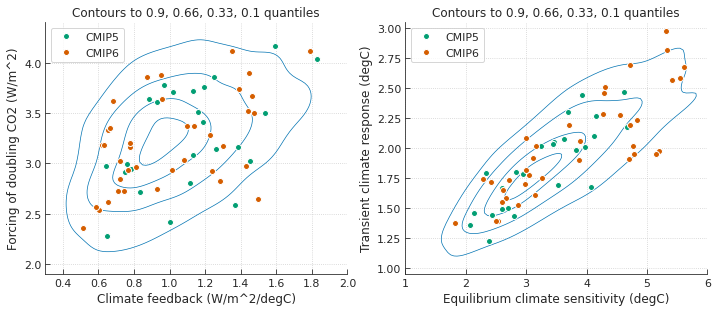

In [12]:
ns = nsize
gaussian_kde = scipy.stats.gaussian_kde
df_parms_p = df_parms_p_climate.copy()

df_parms_cmip['erf|2xCO2'] = df_parms_cmip['alpha'] * np.log(2)
df_parms_p['erf|2xCO2'] = df_parms_p['alpha'] * np.log(2)

variables = {
    'lambda': Variable('Climate feedback', 'W/m^2/degC'),
    'ecs_reg': Variable('Equilibrium climate sensitivity', 'degC'),
    'tcr': Variable('Transient climate response', 'degC'),
    'erf|2xCO2': Variable('Forcing of doubling CO2', 'W/m^2'),
}

map_lim = {
    'ecs_reg': (1., 6.),
    'tcr': (0.95, 3.05),
    'lambda': (0.3, 2.),
    'erf|2xCO2': (1.9, 4.4),
}
map_colors = {
    'cmip5': 'C2',
    'cmip6': 'C3',
}
kw_plot_cmip = {'ls': 'None', 'marker': 'o', 'mec': 'w'}
qlevels = [0.90, 0.66, 0.33, 0.1]

p1 = wrap_plotspace(2, col=2, kw_space={'height': 3.5, 'aspect': 1.2})

for n, (xvar, yvar) in enumerate([('lambda', 'erf|2xCO2'), ('ecs_reg', 'tcr')]):
    ax = p1.figure.axes[n]
    for mip, df in df_parms_cmip.groupby('mip'):
        ax.plot(
            df[xvar].values, df[yvar].values, color=map_colors[mip],
            label=mip.upper(), **kw_plot_cmip)

    ax.legend()

    xlim = map_lim[xvar]
    ylim = map_lim[yvar]

    pdf = gaussian_kde(df_parms_p.loc[:ns, [xvar, yvar]].T.values)
    pvals = pdf(df_parms_p.loc[:ns, [xvar, yvar]].T.values)
    levels = get_contour_levels(pvals, qlevels)
    xp, yp = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    positions = np.vstack([xp.ravel(), yp.ravel()])
    zp = pdf(positions).reshape(xp.shape)
    ax.contour(xp, yp, zp, levels, colors='C0', linewidths=0.7)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid()
    ax.set_xlabel('{} ({})'.format(*variables[xvar]))
    ax.set_ylabel('{} ({})'.format(*variables[yvar]))
    ax.set_title('Contours to {} quantiles'.format(', '.join([f'{x}' for x in qlevels])))
    p1.despine(ax)

## Ocean carbon cycle parameters

The IRM for the airborne fraction defines five components, one of which has infinity time constant, paired with an amplitude corresponding to an asymptotic long-term fraction. In the current configuration, the remaining four time constants are fixed at 236.5, 59.52, 12.17, and 1.271 years, adjusted to a specific three-dimensional ocean carbon cycle model in Hooss et al. (2001, http://dx.doi.org/10.1007/s003820100170). The corresponding amplitudes assume perturbations at reference values of 0.24, 0.21, 0.25, and 0.1, respectively, with a reference long-term airborne fraction of 0.20. These reference values and perturbation ranges are set empirically so that resulting carbon budgets&mdash;cumulative land and ocean CO<sub>2</sub> uptake&mdash;agree with those of historical observations and CMIP experiments.

The perturbations are generated with a uniform distribution for each of the amplitudes, except for the one corresponding to the shortest time constant. Since the sum of the amplitudes is unity, their perturbed values are normalized as such, subject to a modified distribution with more samples about the mean resulting from the operation.

In [13]:
rwa_ref = np.array([0.20, 0.24, 0.21, 0.25, 0.1])
perturb_ocean = 0.05
# seeding is arbitrary, but different from that for the other parameter components
seed_ocean = 11

np.random.seed(seed_ocean)
rwa = rwa_ref.reshape((1, -1)) + np.zeros((nsize, len(rwa_ref)))
rnd = (np.random.rand(nsize, 4)/0.5 - 1.) * perturb_ocean
rwa[:, :4] = rwa[:, :4] + rnd
rwa[:, :4] *= (rwa_ref[:4].sum() / rwa[:, :4].sum(axis=1)).reshape((-1, 1))

df_parms_p_ocean = pd.DataFrame(rwa).rename(columns=lambda x: f'amp{x}')

In [14]:
names_parm.update({
    'amp0': Variable('Airborne fraction for infinity response time', 'dimensionless'),
})
names_parm.update({
    f'amp{i}': Variable(f'Airborne fraction for response time {i}', 'dimensionless')
    for i in range(1, 5)
})

### Box model parameters

The box model converted from the IRM for the airborne fraction is as follows:
$$
\frac{d c_{0}}{d t} = - \frac{\eta_{1}}{h_{s}} c_{s} + \frac{\eta_{1}}{h_{1}} c_{1} + e - f,
$$
$$
\frac{d c_{1}}{d t} = \frac{\eta_{1}}{h_{s}} c_{s} - \frac{\eta_{1} + \eta_{2}}{h_{1}} c_{1} + \frac{\eta_{2}}{h_{2}} c_{2},
$$
$$
\frac{d c_{2}}{d t} = \frac{\eta_{2}}{h_{1}} c_{1} - \frac{\eta_{2} + \eta_{3}}{h_{2}} c_{2} + \frac{\eta_{3}}{h_{3}} c_{3},
$$
$$
\frac{d c_{3}}{d t} = \frac{\eta_{3}}{h_{2}} c_{2} - \frac{\eta_{3}}{h_{3}} c_{3},
$$
where $c_k$ is the amount of excess carbon in layer $k$, $h_k$ is the layer depth, $\eta_k$ is the exchange coefficient between layer $k-1$ and layer $k$, $e$ is anthropogenic emissions, and $f$ is natural uptake over land. The parameters $h_k$ and $\eta_k$ are set through numerical optimization for the box model to be equivalent to the IRM form.

The top layer, indexed with "0," is the composite atmosphere-ocean mixed layer, and the three sub-surface layers are indexed with "1," "2," and "3" in the order of ocean depth. The amount of excess carbon in the top layer ($c_0$) is partitioned into atmospheric and ocean components, denoted by $c_a$ and $c_s$, subject to chemical equilibrium at the ocean surface. The carbon exchange between the top layer and the first sub-surface is expressed in terms of $c_s$.

### Pre-industrial CO<sub>2</sub> concentrations

The box model parameters depend on pre-industrial CO<sub>2</sub> concentrations. Here, numerical optimization is conducted to have the box-model parameters calibrated with 1750 and 1850 levels. Historical CO<sub>2</sub> concentrations can be looked up from RCMIP time series.

In [15]:
df_conc = input_rcmip.get_data_series(
    'concentrations', 'historical',
    drop_elem_vname=['Atmospheric Concentrations'],
    id_vars=['Variable', 'Unit'], is_dropna=True, period=[1750, None],
)
df_conc.loc[('CO2', 'ppm'), [1750, 1850]]

1750    277.147003
1850    284.316999
Name: (CO2, ppm), dtype: float64

In [16]:
ocean = ModelOcean()
rwt_ref = ocean.parms['tau_ref']

for year_pi in [1750, 1850]:
    cco2_pi = df_conc.loc[('CO2', 'ppm'), year_pi]
    rets = []
    for i in range(nsize):
        rets.append(calib_ocean(rwt_ref, rwa[i], ocean.ppm2dic, cco2_pi=cco2_pi))

    df_parms_p_ocean = pd.concat([
        df_parms_p_ocean,
        pd.DataFrame(rets).rename(columns=lambda x: '{}__init{}'.format(x, year_pi))
    ], axis=1, sort=False)

    names_parm.update({
        '{}__init{}'.format(name, year_pi): Variable(f'{long_name}', f'{units}')
        for name, long_name, units in [
            ('hls', 'Surface layer depth', 'm'),
            ('hl1', 'Layer-1 depth', 'm'),
            ('hl2', 'Layer-2 depth', 'm'),
            ('hl3', 'Layer-3 depth', 'm'),
            ('eta1', 'Exchange coefficient between surface and layer-1', 'm/yr'),
            ('eta2', 'Exchange coefficient between layer-1 and layer-2', 'm/yr'),
            ('eta3', 'Exchange coefficient between layer-2 and layer-3', 'm/yr'),
            ('sigc_pi', 'Preindustrial DIC concentration', 'mol/L'),
        ]
    })

### Glance at the generated parameters

In [17]:
display(df_parms_p_ocean.head())

for name in df_parms_p_ocean:
    print('{}: {} ({})'.format(name, *names_parm[name]))

,amp0,amp1,amp2,amp3,amp4,hls__init1750,hl1__init1750,hl2__init1750,hl3__init1750,eta1__init1750,...,eta3__init1750,sigc_pi__init1750,hls__init1850,hl1__init1850,hl2__init1850,hl3__init1850,eta1__init1850,eta2__init1850,eta3__init1850,sigc_pi__init1850
0,0.180289,0.205955,0.221378,0.292378,0.1,70.394507,566.524394,1024.744396,1218.876197,22.381354,...,4.143772,0.002162,72.752653,585.502396,1059.072310,1259.707333,23.131107,9.220679,4.282584,0.002168
1,0.205595,0.255406,0.172679,0.266321,0.1,70.394507,472.179736,809.018846,1096.409559,20.230219,...,4.034691,0.002162,72.752653,487.997286,836.120170,1133.138185,20.907911,7.071678,4.169849,0.002168
2,0.228175,0.257049,0.217724,0.197051,0.1,70.394507,376.979061,754.232331,941.438379,16.375691,...,3.388273,0.002162,72.752653,389.607484,779.498361,972.975625,16.924260,7.378837,3.501777,0.002168
3,0.225639,0.259878,0.166370,0.248113,0.1,70.394507,430.285744,726.845425,946.724018,18.991886,...,3.630503,0.002162,72.752653,444.699887,751.194021,978.438328,19.628095,6.495095,3.752121,0.002168
4,0.179785,0.238463,0.226595,0.255156,0.1,70.394507,493.973251,990.322817,1335.689144,20.165164,...,4.415025,0.002162,72.752653,510.520862,1023.497643,1380.433397,20.840677,8.844791,4.562924,0.002168


amp0: Airborne fraction for infinity response time (dimensionless)
amp1: Airborne fraction for response time 1 (dimensionless)
amp2: Airborne fraction for response time 2 (dimensionless)
amp3: Airborne fraction for response time 3 (dimensionless)
amp4: Airborne fraction for response time 4 (dimensionless)
hls__init1750: Surface layer depth (m)
hl1__init1750: Layer-1 depth (m)
hl2__init1750: Layer-2 depth (m)
hl3__init1750: Layer-3 depth (m)
eta1__init1750: Exchange coefficient between surface and layer-1 (m/yr)
eta2__init1750: Exchange coefficient between layer-1 and layer-2 (m/yr)
eta3__init1750: Exchange coefficient between layer-2 and layer-3 (m/yr)
sigc_pi__init1750: Preindustrial DIC concentration (mol/L)
hls__init1850: Surface layer depth (m)
hl1__init1850: Layer-1 depth (m)
hl2__init1850: Layer-2 depth (m)
hl3__init1850: Layer-3 depth (m)
eta1__init1850: Exchange coefficient between surface and layer-1 (m/yr)
eta2__init1850: Exchange coefficient between layer-1 and layer-2 (m/yr

## Land carbon cycle parameters

The IRM for land carbon defines four carbon pools, representing ground vegetation, wood, detritus, and soil organic carbon, with distinct overturning times ($\tau_{i}$). The forcing term ($F$) is net primary production (NPP) enhanced by the effect of CO<sub>2</sub> fertilization, generally expressed by $\beta_{L} N_{0}$, where $\beta_{L}$ is a fertilization factor that depends on the atmospheric CO<sub>2</sub> concentration, and $N_{0}$ is base annual NPP in GtC per year.

The response amplitude ($A_{i}$) is rewritten as $\tilde{A}_{bi} \tau_{i}$, where $\tilde{A}_{bi}$ denotes a decay flux after an initial carbon input. Based on Joos et al. (1996, https://doi.org/10.3402/tellusb.v48i3.15921), the IRM parameters of the four carbon pools are set to 2.9, 20, 2.2, and 100 years for $\tau_{i}$, and 0.70211, 0.013414, &minus;0.71846, and 0.0029323 years<sup>&minus;1</sup> for $\tilde{A}_{bi}$, respectively.

The MCE deals with temperature dependency for the time constants of wood and soil organic carbon, indicating the tendency for warming to accelerate the decomposition of organic matter. This is one of the climate-carbon cycle feedback processes and is implemented with an adjustment coefficient varied along a logistic curve with respect to surface warming. This scheme has a parameter to control the asymptotic minimum value of the coefficient.

The land carbon uptake term $f$ in the above box model form is calculated from the time derivative of the IRM formula, rewritten as:
$$
f(t) = \sum_{i} \left[
\beta_{L}(t) N_{0} \tilde{A}_{bi} \tau_{i} - \frac{c_{bi}}{\tau_{i}} \right],
$$
where $c_{bi}$ is the $i$-th component of accumulated carbon by CO<sub>2</sub> fertilization. The base NPP ($N_{0}$) is set to 60 GtC/yr and the fertilization factor ($\beta_{L}$) is formulated with a sigmoid curve with regard to CO<sub>2</sub> concentration, as described in Meinshausen et al. (2011, https://doi.org/10.5194/acp-11-1417-2011). This implementation is connected to a conventional logarithmic formula:
$$
\beta_{L} = 1 + \hat{\beta}_{L} \ln [\mathrm{CO_{2}(t)/\mathrm{CO_{2}(0)}}],
$$
such that the sigmoid and logarithmic curves are equal in terms of an increase ratio at 680 ppm relative to 340 ppm, and the latter factor $\hat{\beta}_{L}$ is used as a control parameter.

Here, the two control parameters for land carbon decay timescales and CO<sub>2</sub> fertilization are selected as those to be perturbed. Perturbation is based on a uniform distribution around a given reference value with a given uncertainty range.

In [18]:
beta_ref = 0.43
perturb_land_beta = 0.30
fb_alpha_ref = 0.87
perturb_land_fb_alpha = 0.13

# seeding is arbitrary, but different from that for the other parameter components
seed_land = 21
np.random.seed(seed_land)
rnd = np.random.rand(2*nsize)/0.5 - 1.

df_parms_p_land = pd.DataFrame([
    beta_ref + rnd[:nsize] * perturb_land_beta, 
    fb_alpha_ref + rnd[nsize:] * perturb_land_fb_alpha,
], index=['beta', 'fb_alpha']).T

names_parm.update({
    'beta':
    Variable('Control parameter of CO2 fertilization effect', 'dimensionless'),
    'fb_alpha':
    Variable('Control parameter to adjust land carbon overturning times', 'dimensionless'),
})

### Glance at the generated parameters

In [19]:
display(df_parms_p_land.head())

for name in df_parms_p_land:
    print('{}: {} ({})'.format(name, *names_parm[name]))

,beta,fb_alpha
0,0.159235,0.972120
1,0.303466,0.932916
2,0.562580,0.984677
3,0.142970,0.955566
4,0.253554,0.816463


beta: Control parameter of CO2 fertilization effect (dimensionless)
fb_alpha: Control parameter to adjust land carbon overturning times (dimensionless)


## Compare carbon budget indicators between the perturbed ensemble and CMIP model ensemble

### Save all the generated parameters in a NetCDF file

In [20]:
ncpath = '../untracked/parms_perturbed_model.nc'
ncf = Dataset(ncpath, 'w')
ncf.createDimension('ensemble_member', nsize)

v = ncf.createVariable(
    'ensemble_member', 'int64', ('ensemble_member',))
v[:] = np.arange(nsize)

for df_parms_p, prefix in [
    (df_parms_p_climate, 'climate'),
    (df_parms_p_ocean, 'carbon'),
    (df_parms_p_land, 'carbon'),
]:
    for name in df_parms_p:
        v = ncf.createVariable(
            f'{prefix}__{name}', 'float64', ('ensemble_member',),
            fill_value=np.nan)
        v.long_name = names_parm[name].long_name
        v.units = names_parm[name].units
        v[:] = df_parms_p[name].values

ncf.close()

### Create an instance to manipulate the parameter file

In [21]:
obj_pp = ParmsPerturbed(ncpath)

### Prepare input time series for 1%-per-year CO<sub>2</sub> increase experiment

In [22]:
yinit = 1850
time, kw_driver = input_rcmip.get_input_cdrv(
    '1pctCO2', period=[yinit, yinit+150], co2_only=True
)
cco2_pi = kw_driver['cco2'][0]
# the initial CO2 concentration is the same as the historical concentration in 1850
print(cco2_pi, cco2_pi==df_conc.loc[('CO2', 'ppm'), yinit])

284.3169987996419 True


### Conduct ensemble runs

In [23]:
dfout = []

for im in range(nsize):
    kw_parms_all = obj_pp.get_parms_all(
        im, co2_only=True, yinit=1850,
        conc_pi={('CO2', 'ppm'): kw_driver['cco2'][0]},
    )
    kw_driver.update(kw_parms_all)
    drv = Driver(time, **kw_driver)
    df = drv.run({})
    df.index = pd.MultiIndex.from_product(
        [df.index, [im]], names=['variable', 'member'])
    dfout.append(df)

dfout = pd.concat(dfout).sort_index()

In [24]:
obj_pp.close()

### Gather indicators associated with carbon budget

In [25]:
df_indicator = []
names_indicator = {}

for vn, year, long_name, units in [
    ('tas', 70, 'Transient temperature response in 70th year', 'degC'),
    ('tas', 140, 'Transient temperature response in 140th year', 'degC'),
    ('tcre', 70,
     'Transient temperature response to cumulative CO2 emissions in 70th year',
     'degC/1000 GtC'),
    ('tcre', 140,
     'Transient temperature response to cumulative CO2 emissions in 140th year',
     'degC/1000 GtC'),
    ('coct', 70, 'Accumulated carbon over ocean by 70th year', 'GtC'),
    ('coct', 140, 'Accumulated carbon over ocean by 140th year', 'GtC'),
    ('cbst', 70, 'Accumulated carbon over land by 70th year', 'GtC'),
    ('cbst', 140, 'Accumulated carbon over land by 140th year', 'GtC'),
    ('ctot', 70, 'Implied cumulative CO2 emissions by 70th year', 'GtC'),
    ('ctot', 140, 'Implied cumulative CO2 emissions by 140th year', 'GtC'),
]:
    name = '{}|{}'.format(vn, {70: '2x', 140: '4x'}[year])
    df_indicator.append(
        dfout.loc[vn][yinit+year].rename(name)
    )
    names_indicator[name] = Variable(long_name, units)

df_indicator = pd.DataFrame(df_indicator).T
display(
    df_indicator.head(),
    names_indicator
)

,tas|2x,tas|4x,tcre|2x,tcre|4x,coct|2x,coct|4x,cbst|2x,cbst|4x,ctot|2x,ctot|4x
member,,,,,,,,,,
0,2.088431,4.840691,2.099577,1.742177,273.740973,713.503778,114.188764,240.638244,994.691142,2778.529988
1,1.965019,4.565797,1.877443,1.590227,240.793281,616.487155,199.091460,430.286062,1046.646146,2871.161183
2,1.968938,4.400914,1.679873,1.336202,206.264865,537.539164,359.049543,931.672269,1172.075813,3293.599399
3,1.921580,4.311732,2.062809,1.659505,225.988840,575.827582,98.785431,197.988008,931.535677,2598.203557
4,1.593845,3.506795,1.578935,1.272454,255.039374,674.236871,147.642364,257.305584,1009.443143,2755.930421


{'tas|2x': Variable(long_name='Transient temperature response in 70th year', units='degC'),
 'tas|4x': Variable(long_name='Transient temperature response in 140th year', units='degC'),
 'tcre|2x': Variable(long_name='Transient temperature response to cumulative CO2 emissions in 70th year', units='degC/1000 GtC'),
 'tcre|4x': Variable(long_name='Transient temperature response to cumulative CO2 emissions in 140th year', units='degC/1000 GtC'),
 'coct|2x': Variable(long_name='Accumulated carbon over ocean by 70th year', units='GtC'),
 'coct|4x': Variable(long_name='Accumulated carbon over ocean by 140th year', units='GtC'),
 'cbst|2x': Variable(long_name='Accumulated carbon over land by 70th year', units='GtC'),
 'cbst|4x': Variable(long_name='Accumulated carbon over land by 140th year', units='GtC'),
 'ctot|2x': Variable(long_name='Implied cumulative CO2 emissions by 70th year', units='GtC'),
 'ctot|4x': Variable(long_name='Implied cumulative CO2 emissions by 140th year', units='GtC')}

### Prepare CMIP Earth system model data
Adopted from Arora et al. (2020, https://doi.org/10.5194/bg-17-4173-2020) Figure 4 and Figure A2.

In [26]:
text = """# Arora et al. (2020) Figure 4 and Figure A2
model          mip     coct|2x  cbst|2x  ctot|2x  coct|4x  cbst|4x  ctot|4x
ACCESS-ESM1-5  cmip6    276.     188.     1064.    662.     215.     2693.
UKESM1-0-LL    cmip6    229.     224.     1054.    554.     408.     2779.
IPSL-CM6A-LR   cmip6    229.     283.     1107.    579.     477.     2856.
GFDL-ESM4      cmip6    261.     229.     1066.    645.     499.     2922.
MPI-ESM1-2-LR  cmip6    229.     304.     1127.    575.     586.     2961.
CESM2          cmip6    229.     248.     1073.    551.     656.     3010.
MIROC-ES2L     cmip6    224.     315.     1135.    546.     701.     3049.
NorESM2-LM     cmip6    237.     244.     1075.    599.     652.     3050.
CNRM-ESM2-1    cmip6    224.     305.     1124.    547.     715.     3063.
BCC-CSM2-MR    cmip6    288.     406.     1291.    706.     875.     3390.
CanESM5        cmip6    234.     385.     1214.    562.     1204.    3566.
MIROC-ESM      cmip5    238.     151.     985.     580.     149.     2532.
CESM1-BGC      cmip5    232.     62.      893.     575.     176.     2563.
NorESM1-ME     cmip5    266.     69.      934.     667.     172.     2652.
CanESM2        cmip5    224.     183.     1006.    533.     494.     2839.
HadGEM2-ES     cmip5    232.     350.     1181.    587.     768.     3169.
BCC-CSM1.1     cmip5    268.     381.     1248.    647.     716.     3176.
IPSL-CM5A-LR   cmip5    264.     381.     1240.    670.     741.     3214.
MPI-ESM-LR     cmip5    256.     403.     1258.    632.     825.     3270.
"""

df_parms_cmip_esm = pd.read_table(StringIO(text), comment='#', delim_whitespace=True)

### Compare each indicator between the perturbed ensemble and the CMIP ensemble

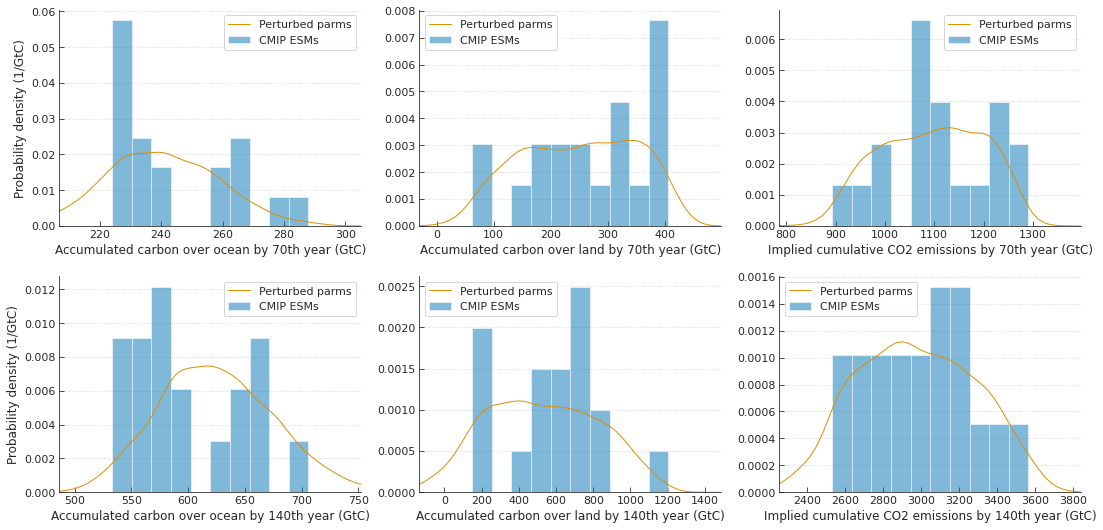

In [27]:
names = [
    'coct|2x', 'cbst|2x', 'ctot|2x',
    'coct|4x', 'cbst|4x', 'ctot|4x',
]
col = 3
p1 = wrap_plotspace(len(names), col=col)
for n, name in enumerate(names):
    ax = p1.figure.axes[n]
    ax.hist(df_parms_cmip_esm[name], alpha=0.5, density=True, label='CMIP ESMs')
    kde = scipy.stats.gaussian_kde(df_indicator[name])
    xlim = ax.get_xlim()
    xlim_ext = (
        xlim[0] - 0.2*(xlim[1]-xlim[0]),
        xlim[1] + 0.2*(xlim[1]-xlim[0]),
    )
    xval = np.linspace(*xlim_ext)
    ax.plot(xval, kde(xval), label='Perturbed parms')
    ax.legend()
    ax.set_xlim(*xlim_ext)
    ax.set_xlabel('{} ({})'.format(*names_indicator[name]))
    if n%col == 0:
        ax.set_ylabel('Probability density (1/GtC)')
    ax.grid(axis='y')
    p1.despine(ax)

## Sampling with an acceptance-rejection algorithm

A Metropolis-Hastings (MH) sampler can be used to reject a number of ensemble members so that accepted samples better fit the CMIP ensemble.

### Make a target probability density function

Here, fitting a skewed normal distribution to the CMIP land accumulated carbon in the 70th year.

In [28]:
stat_model = StatModel()
name_target = 'cbst|2x'
constraints = {
    'very_likely__lower': df_parms_cmip_esm[name_target].quantile(0.05),
    'central': df_parms_cmip_esm[name_target].mean(), # consider mean value as median
    'very_likely__upper': df_parms_cmip_esm[name_target].quantile(0.95),
}
rv = stat_model.get_rv('skewnorm', constraints, a=0., loc=270., scale=50.)
print(name_target, rv.args, rv.kwds)

cbst|2x (-2.761983351435631,) {'loc': 373.328278554515, 'scale': 155.62953259861692}


### Conduct sampling with the target density

In [29]:
obj_mh = SamplingMH(df_indicator[name_target], rv.pdf)
index1, index1a = obj_mh.sampling()
print('acceptance rate', len(index1a)/len(index1))

acceptance rate 0.831


### Compare the indicators

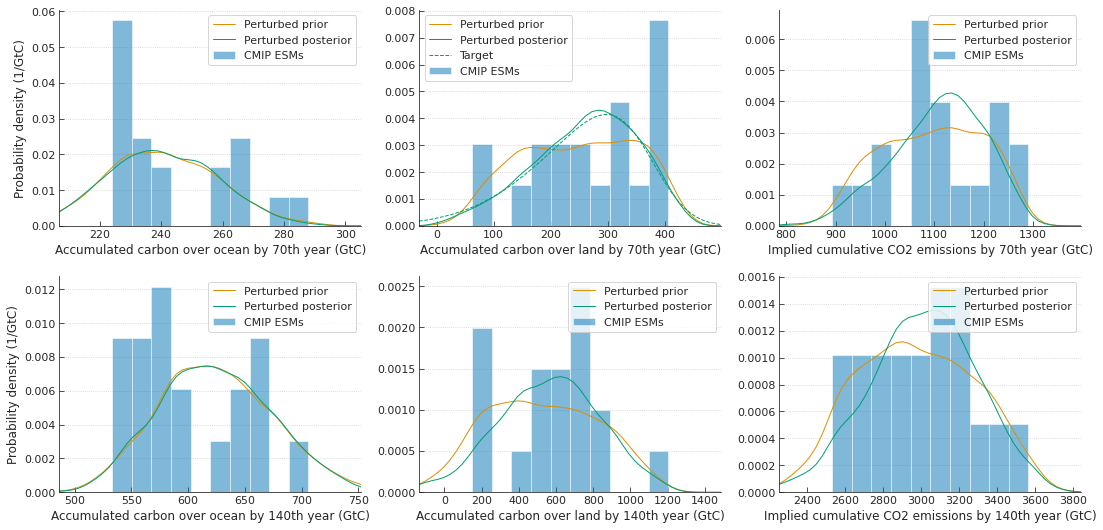

In [30]:
names = [
    'coct|2x', 'cbst|2x', 'ctot|2x',
    'coct|4x', 'cbst|4x', 'ctot|4x',
]
col = 3
p1 = wrap_plotspace(len(names), col=col)
for n, name in enumerate(names):
    ax = p1.figure.axes[n]
    ax.hist(df_parms_cmip_esm[name], alpha=0.5, density=True, label='CMIP ESMs')

    kde = scipy.stats.gaussian_kde(df_indicator[name])
    xlim = ax.get_xlim()
    xlim_ext = (
        xlim[0] - 0.2*(xlim[1]-xlim[0]),
        xlim[1] + 0.2*(xlim[1]-xlim[0]),
    )
    xval = np.linspace(*xlim_ext)
    ax.plot(xval, kde(xval), label='Perturbed prior')

    kde = scipy.stats.gaussian_kde(df_indicator.loc[index1, name])
    ax.plot(xval, kde(xval), label='Perturbed posterior')

    if name == name_target:
        ax.plot(xval, rv.pdf(xval), color='C2', ls='--', label='Target')

    ax.legend()
    ax.set_xlim(*xlim_ext)
    ax.set_xlabel('{} ({})'.format(*names_indicator[name]))
    if n%col == 0:
        ax.set_ylabel('Probability density (1/GtC)')
    ax.grid(axis='y')
    p1.despine(ax)

### Additional indicators for diagnostics

In [31]:
for dfx in [df_parms_cmip_esm, df_indicator]:
    dfx['coct+cbst|2x'] = dfx['coct|2x'] + dfx['cbst|2x']
    dfx['coct+cbst|4x'] = dfx['coct|4x'] + dfx['cbst|4x']
    dfx['coct_ratio|2x'] = dfx['coct|2x'] / dfx['coct+cbst|2x']
    dfx['coct_ratio|4x'] = dfx['coct|4x'] / dfx['coct+cbst|4x']

names_indicator.update({
    'coct+cbst|2x':
    Variable('Total accumulated carbon by 70th year', 'GtC'),
    'coct+cbst|4x':
    Variable('Total accumulated carbon by 140th year', 'GtC'),
    'coct_ratio|2x':
    Variable(
        'Ratio of accumulated carbon over ocean by 70th year',
        'dimensionless'),
    'coct_ratio|4x':
    Variable(
        'Ratio of accumulated carbon over ocean by 140th year',
        'dimensionless'),
})    

### Plot characterirstic parameter relationships associated with carbon cycle

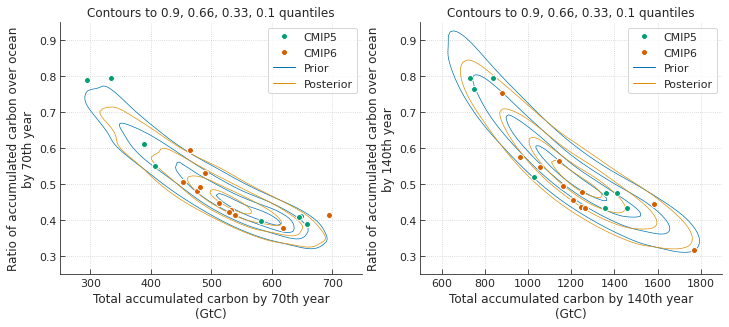

In [32]:
map_lim = {
    'coct+cbst|2x': (250., 750.),
    'coct+cbst|4x': (500., 1900.),
    'coct_ratio|2x': (0.25, 0.95),
    'coct_ratio|4x': (0.25, 0.95),
}
map_colors = {
    'cmip5': 'C2',
    'cmip6': 'C3',
}
kw_plot_cmip = {'ls': 'None', 'marker': 'o', 'mec': 'w'}
qlevels = [0.90, 0.66, 0.33, 0.1]

p1 = wrap_plotspace(2, col=2, kw_space={'height': 3.5, 'aspect': 1.2})

for n, (xvar, yvar) in enumerate([
    ('coct+cbst|2x', 'coct_ratio|2x'),
    ('coct+cbst|4x', 'coct_ratio|4x'),
]):
    ax = p1.figure.axes[n]
    for mip, df in df_parms_cmip_esm.groupby('mip'):
        ax.plot(
            df[xvar].values, df[yvar].values, color=map_colors[mip],
            label=mip.upper(), **kw_plot_cmip)

    handles, labels = ax.get_legend_handles_labels()
    xlim = map_lim[xvar]
    ylim = map_lim[yvar]

    pdf = gaussian_kde(df_indicator.loc[:, [xvar, yvar]].T.values)
    pvals = pdf(df_indicator.loc[:, [xvar, yvar]].T.values)
    levels = get_contour_levels(pvals, qlevels)
    xp, yp = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    positions = np.vstack([xp.ravel(), yp.ravel()])
    zp = pdf(positions).reshape(xp.shape)
    ax.contour(xp, yp, zp, levels, colors='C0', linewidths=0.7)
    handles.append(mpl.lines.Line2D([], [], color='C0'))
    labels.append('Prior')

    pdf = gaussian_kde(df_indicator.loc[index1, [xvar, yvar]].T.values)
    pvals = pdf(df_indicator.loc[index1, [xvar, yvar]].T.values)
    levels = get_contour_levels(pvals, qlevels)
    zp = pdf(positions).reshape(xp.shape)
    ax.contour(xp, yp, zp, levels, colors='C1', linewidths=0.7)
    handles.append(mpl.lines.Line2D([], [], color='C1'))
    labels.append('Posterior')

    ax.legend(handles, labels)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid()
    ax.set_xlabel('\n'.join(textwrap.wrap(
        '{} ({})'.format(*names_indicator[xvar]), 40)))
    ax.set_ylabel('\n'.join(textwrap.wrap(
        names_indicator[yvar].long_name, 40)))
    ax.set_title('Contours to {} quantiles'.format(', '.join([f'{x}' for x in qlevels])))
    p1.despine(ax)